# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Load Dataset

In [2]:
!mkdir dataset
datasetURL = 'http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'
os.chdir('dataset')
dataset = tf.keras.utils.get_file("stack_overflow", datasetURL,
                  extract=True, cache_dir='.',
                  cache_subdir='',
                  archive_format='tar')
os.chdir('..')

mkdir: cannot create directory ‘dataset’: File exists


In [3]:
DATASET_DIR = os.path.join(os.path.dirname(dataset), 'dataset')
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
TEST_DIR = os.path.join(DATASET_DIR, 'test')

In [4]:
batch_size = 32
seed = 42
train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    TRAIN_DIR, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [5]:
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    TRAIN_DIR, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [6]:
test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    TEST_DIR, 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model

In [8]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                  '[%s]' % re.escape(string.punctuation),
                  '')

In [10]:
# Train a vectorization layer
max_features = 10000
sequence_length = 250
'''
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)
'''
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features)
train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [11]:
embedding_dim = 16
model = tf.keras.Sequential([
  vectorize_layer,                
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(16,activation='relu'),
  layers.Dense(4,activation='softmax')])

In [12]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 4s 15ms/step - loss: 1.3825 - accuracy: 0.2844 - val_loss: 1.3756 - val_accuracy: 0.3469
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 1.3539 - accuracy: 0.3944 - val_loss: 1.3210 - val_accuracy: 0.4787
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 1.2569 - accuracy: 0.5420 - val_loss: 1.1748 - val_accuracy: 0.6281
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 1.0863 - accuracy: 0.6364 - val_loss: 0.9974 - val_accuracy: 0.6706
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.9206 - accuracy: 0.6966 - val_loss: 0.8587 - val_accuracy: 0.7144
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 0.7978 - accuracy: 0.7322 - val_loss: 0.7593 - val_accuracy: 0.7487
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 0.7034 - accuracy: 0.7636 - val_loss: 0.6927 - val_accuracy: 0.7700

In [13]:
examples = [
'''
How do I sort a list of dictionaries by a value of the dictionary?
I have a list of dictionaries and want each item to be sorted by a specific value.
Take into consideration the list:
[{'name':'Homer', 'age':39}, {'name':'Bart', 'age':10}]
When sorted by name, it should become:
[{'name':'Bart', 'age':10}, {'name':'Homer', 'age':39}]
''',
'''
Validate Map<String,Object> object matches json schema
I want to check whether an object of type Map<String,Object> matches the schema or not. The schema is received as a String.
How can I achieve this? (Preferably using Jackson)
Thanks.
'''
]

model.predict(examples)

array([[0.05053845, 0.08308301, 0.02675996, 0.83961856],
       [0.5179985 , 0.30583033, 0.15187894, 0.02429225]], dtype=float32)

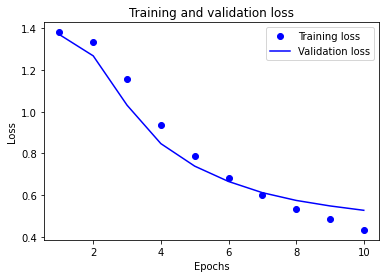

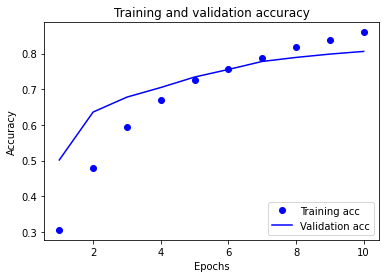

In [14]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()



---



# TF Hub

In [15]:
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [16]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

In [17]:
model2 = tf.keras.Sequential()
model2.add(hub_layer)
layers.Dropout(0.2),
layers.GlobalAveragePooling1D(),
layers.Dropout(0.2),
model2.add(tf.keras.layers.Dense(16, activation='relu'))
model2.add(tf.keras.layers.Dense(4,activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense_2 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 48,191,484
Trainable params: 48,191,484
Non-trainable params: 0
_________________________________________________________________


In [18]:
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
epochs = 10
history = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 112s 556ms/step - loss: 1.2064 - accuracy: 0.4731 - val_loss: 0.9201 - val_accuracy: 0.6869
Epoch 2/10
200/200 [==============================] - 114s 568ms/step - loss: 0.7089 - accuracy: 0.7478 - val_loss: 0.6453 - val_accuracy: 0.7538
Epoch 3/10
200/200 [==============================] - 111s 557ms/step - loss: 0.4238 - accuracy: 0.8627 - val_loss: 0.5772 - val_accuracy: 0.7606
Epoch 4/10
200/200 [==============================] - 111s 555ms/step - loss: 0.2482 - accuracy: 0.9359 - val_loss: 0.5764 - val_accuracy: 0.7713
Epoch 5/10
200/200 [==============================] - 110s 551ms/step - loss: 0.1357 - accuracy: 0.9736 - val_loss: 0.6122 - val_accuracy: 0.7700
Epoch 6/10
200/200 [==============================] - 116s 581ms/step - loss: 0.0691 - accuracy: 0.9914 - val_loss: 0.6580 - val_accuracy: 0.7688
Epoch 7/10
200/200 [==============================] - 114s 571ms/step - loss: 0.0350 - accuracy: 0.9983 - val_loss: 0.7022 -

# RNN

In [14]:
model3 = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax')
])

In [15]:
model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
epochs = 10
history = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 181s 850ms/step - loss: 1.1090 - accuracy: 0.4919 - val_loss: 0.7786 - val_accuracy: 0.6750
Epoch 2/10
200/200 [==============================] - 165s 827ms/step - loss: 0.5985 - accuracy: 0.7758 - val_loss: 0.7220 - val_accuracy: 0.7519
Epoch 3/10
200/200 [==============================] - 167s 835ms/step - loss: 0.3877 - accuracy: 0.8606 - val_loss: 0.7759 - val_accuracy: 0.7181
Epoch 4/10
200/200 [==============================] - 167s 836ms/step - loss: 0.3290 - accuracy: 0.8811 - val_loss: 0.8556 - val_accuracy: 0.7450
Epoch 5/10
200/200 [==============================] - 168s 842ms/step - loss: 0.2296 - accuracy: 0.9244 - val_loss: 0.7938 - val_accuracy: 0.6806
Epoch 6/10
200/200 [==============================] - 168s 842ms/step - loss: 0.2792 - accuracy: 0.9002 - val_loss: 0.9004 - val_accuracy: 0.6931
Epoch 7/10
200/200 [==============================] - 169s 846ms/step - loss: 0.1570 - accuracy: 0.9523 - val_loss: 0.9278 -